In [1]:
from ipynb.fs.full.BreastFunctions import *
#from BreastFunctions_py import *
import numpy as np
import pandas as pd

In [85]:
# Prepare this dataframe (total results) only once
total_results_dataframe = pd.DataFrame(columns=["Patient to be predicted/left out" , "Metastasis-Free Subpopulation" , "Metastasis Subpopulation" , 
"Metastasis Status", "SAM Features for each tSNE run on new subset"])

# Only load if needed to load total results from previous runs to continue on
#total_results_dataframe = pd.read_csv("total_breastCancer_results.csv")


In [21]:
HE_image , MSI_data_cube , goodlist, peak_list, pixel_to_sample_ID, sample_only_data, sample_only_scaled_data , sample_ID_pixels = ReadBreastData()

In [53]:
## Selecting Patient as test
testPatient_ID = 1
#-------------------------------------------------------

train_scaled_data,train_data,train_ID_pixels,test_scaled_data,test_data,test_ID_pixels = SplitData(ID = testPatient_ID ,
        sample_only_data = sample_only_data,
        sample_only_scaled_data = sample_only_scaled_data,
        sample_ID_pixels = sample_ID_pixels )


In [23]:
tsne_results = tSNE(train_scaled_data)
np.save("BreastCancer_tSNE_Model_Patient_{}".format(testPatient_ID) , tsne_results)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 46718 samples in 0.006s...
[t-SNE] Computed neighbors for 46718 samples in 52.626s...
[t-SNE] Computed conditional probabilities for sample 1000 / 46718
[t-SNE] Computed conditional probabilities for sample 2000 / 46718
[t-SNE] Computed conditional probabilities for sample 3000 / 46718
[t-SNE] Computed conditional probabilities for sample 4000 / 46718
[t-SNE] Computed conditional probabilities for sample 5000 / 46718
[t-SNE] Computed conditional probabilities for sample 6000 / 46718
[t-SNE] Computed conditional probabilities for sample 7000 / 46718
[t-SNE] Computed conditional probabilities for sample 8000 / 46718
[t-SNE] Computed conditional probabilities for sample 9000 / 46718
[t-SNE] Computed conditional probabilities for sample 10000 / 46718
[t-SNE] Computed conditional probabilities for sample 11000 / 46718
[t-SNE] Computed conditional probabilities for sample 12000 / 46718
[t-SNE] Computed conditional probabilities for s

In [54]:
tsne_results = np.load("BreastCancer_tSNE_Model_Patient_{}.npy".format(testPatient_ID))

In [55]:
kmeans_8 , kmeans_7, kmeans_6, kmeans_5 = KMeans_results(tsne_results)

In [56]:
Clinical_data = ReadClinicalData(testPatient_ID , "ClinicalData.xlsx")
Clinical_data_full = pd.read_excel("ClinicalData.xlsx","Breast Cancer Clinical Data")

NonMetastasis: [1. 3. 5. 3. 1. 2. 1. 0.]
Metastasis: [4. 4. 2. 4. 3. 1. 4. 9.]


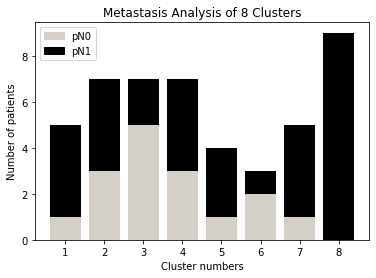

NonMetastasis: [1. 1. 2. 4. 0. 3. 4.]
Metastasis: [7. 3. 1. 6. 9. 4. 2.]


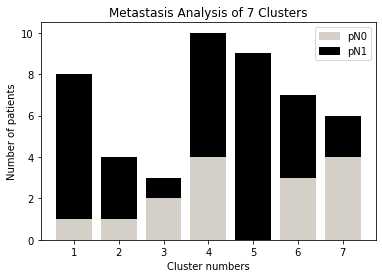

NonMetastasis: [2. 2. 1. 1. 5. 3.]
Metastasis: [8. 1. 5. 7. 4. 5.]


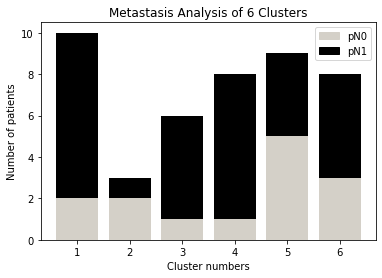

NonMetastasis: [2. 3. 4. 1. 1.]
Metastasis: [8. 3. 4. 6. 5.]


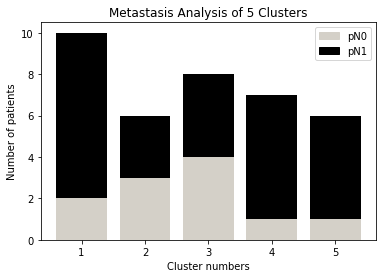

In [57]:
# Returns Non-Metastasis and Metastasis clusters
state08, state18 = metastasis_status(kmeans_8.labels_, Clinical_data,train_ID_pixels)
state07, state17 = metastasis_status(kmeans_7.labels_, Clinical_data,train_ID_pixels)
state06, state16 = metastasis_status(kmeans_6.labels_, Clinical_data,train_ID_pixels)
state05, state15 = metastasis_status(kmeans_5.labels_, Clinical_data,train_ID_pixels)

# Plots bar plot of Non-Metastasis and Metastasis clusters
plot_metastasis_status(state08, state18)
plot_metastasis_status(state07, state17)
plot_metastasis_status(state06, state16)
plot_metastasis_status(state05, state15)

# Create dict to save kmeans results and select them later
kmeans_dict = {}
kmeans_dict["kmeans_clusters"] = [8,7,6,5]
kmeans_dict["Selected_state"] = [state08,state07,state06,state05]
kmeans_dict["kmeans_labels"] = [kmeans_8.labels_,kmeans_7.labels_,kmeans_6.labels_,kmeans_5.labels_]

In [60]:
# Select the correct kmeans that shows best results from metastasis analysis, must have one fully metastasis cluster
selected_clusters_value = 7

# ----------------------------------------------------------------------------------

# Detect the fully metastasis cluster, select the correct kmeans that shows best results from metastasis analysis
selected_state = kmeans_dict["Selected_state"][kmeans_dict["kmeans_clusters"] == selected_clusters_value]
labels = kmeans_dict["kmeans_labels"][kmeans_dict["kmeans_clusters"] == selected_clusters_value]

fully_metastasis_cluster_label = 0
for cluster in selected_state:
    if not cluster: # Cluster list is empty, has no healthy patients, so it's fully metastasis cluster
        break # fully_metastasis_cluster_label now has the right label, exit loop
    
    fully_metastasis_cluster_label += 1

print("Fully metastasis cluster label's index is {} and it is cluster {}".format(fully_metastasis_cluster_label,fully_metastasis_cluster_label+1))

Fully metastasis cluster label's index is 7 and it is cluster 8


In [62]:
protein_dataframe = SAM_Analysis(labels, Clinical_data, train_ID_pixels, fully_metastasis_cluster_label, train_data, peak_list)
protein_dataframe.to_csv("BreastCancerAverageSpectrumValues.csv",index=False)

In [63]:
#Need to read significant protein file outputted from R

SAM_protein = readSignificantProteins("significant_breast_proteins.json",delete=False)

SAM_protein_indices=[]
for i in range(len(peak_list)):

    if peak_list[i][0] in SAM_protein:
        SAM_protein_indices.append(i)

train_scaled_selected_proteins_data = train_scaled_data[:,SAM_protein_indices]
test_scaled_selected_proteins_data = test_scaled_data[:,SAM_protein_indices]

train_selected_proteins_data = train_data[:,SAM_protein_indices]
test_selected_proteins_data = test_data[:,SAM_protein_indices]

In [64]:
train_labels = TargetLabelsCreation(labels , Clinical_data, train_ID_pixels, fully_metastasis_cluster_label)

In [65]:
# Test rbf at c = 0.1 , 1 , 10
# Test linear at c = 0.1 , 1 , 10
y_pred_SVM = SVM("rbf" , 1 , train_scaled_data , train_labels , test_scaled_data)

In [66]:
Metastasis_prob_SVM , Non_Metastasis_prob_SVM = ProbabilityCalc(y_pred_SVM)

Metastasis probability : 96.17242660720922 
Non-Metastasis probability : 3.827573392790784


In [67]:
y_pred_KNN = KNN(5 , train_scaled_data, train_labels, test_scaled_data)

In [68]:
Metastasis_prob_KNN , Non_Metastasis_prob_KNN = ProbabilityCalc(y_pred_KNN)

Metastasis probability : 90.04087699739873 
Non-Metastasis probability : 9.959123002601263


In [69]:
# Selected Metastasis probabilities, select KNN or SVM results
Metastasis_prob = Metastasis_prob_KNN
Non_Metastasis_prob = Non_Metastasis_prob_KNN

In [82]:
# Run after model complete to save the result in the total results dataframe
total_results_dataframe = OutputDataframe(total_results_dataframe, testPatient_ID , Clinical_data_full, Non_Metastasis_prob, Metastasis_prob, SAM_protein)

In [83]:
total_results_dataframe

,Patient to be predicted/left out,Metastasis-Free Subpopulation,Metastasis Subpopulation,Metastasis Status,SAM Features for each tSNE run on new subset
0,1,9.959123,90.040877,1,"Significant Features : m/z = [4999, 4965, 5171..."
0,1,9.959123,90.040877,1,"Significant Features : m/z = [4999, 4965, 5171..."


In [84]:
# Only run if needed to save and load at a later time
total_results_dataframe.to_csv("total_breastCancer_results.csv" , index = False)